# Facial Expression Recognition model training

### Connect to kaggle

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! rm kaggle.json

### Download our cleaned FER13 dataset

In [2]:
! kaggle datasets download -d melekelloumi/fer13-even-more-cleaned-dataset

 46% 25.0M/54.3M [00:00<00:00, 82.8MB/s]
100% 54.3M/54.3M [00:00<00:00, 140MB/s] 


### Download our cleaned FER13 dataset

In [ ]:
! mkdir /content/fer13-even-more-cleaned-dataset
! cp /content/fer13-even-more-cleaned-dataset.zip /content/fer13-even-more-cleaned-dataset/fer13-even-more-cleaned-dataset.zip
! unzip /content/fer13-even-more-cleaned-dataset/fer13-even-more-cleaned-dataset -d /content/fer13-even-more-cleaned-dataset/
! rm /content/fer13-even-more-cleaned-dataset.zip
! rm /content/fer13-even-more-cleaned-dataset/fer13-even-more-cleaned-dataset.zip
! rm -rf /content/fer13-even-more-cleaned-dataset/FER13_cleaner/train/disgust
! rm -rf /content/fer13-even-more-cleaned-dataset/FER13_cleaner/test/disgust

In [ ]:
! pip install livelossplot

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.2


### Get train and test paths

In [ ]:
train_filepath="/content/fer13-even-more-cleaned-dataset/FER13_cleaner/train/"
test_filepath="/content/fer13-even-more-cleaned-dataset/FER13_cleaner/test/"

### Exploring the dataset

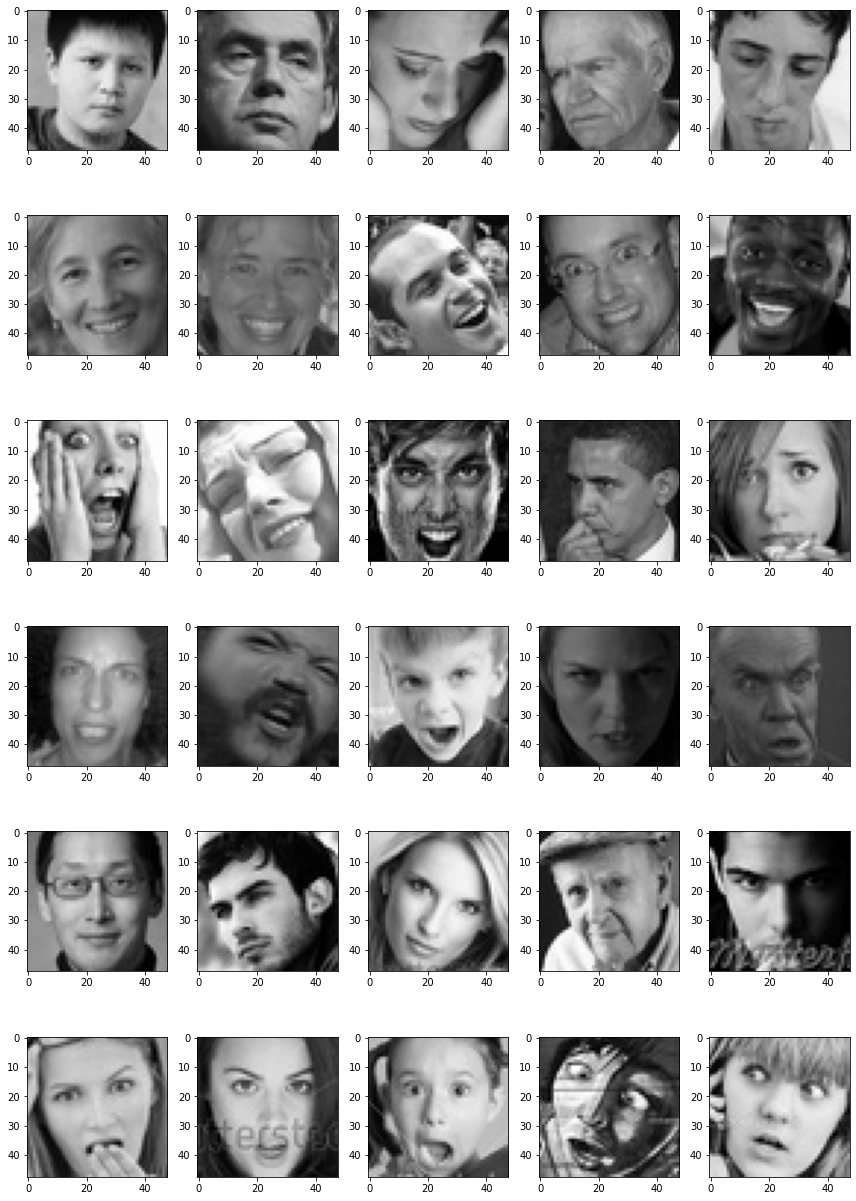

In [3]:
def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0
    for expression in os.listdir(train_filepath):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img(train_filepath + expression + "/" +os.listdir(train_filepath + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

plot_example_images(plt).show()

### Number of images per expression

In [4]:
for expression in os.listdir(train_filepath):
    print(str(len(os.listdir(train_filepath + expression )))+" "+ expression+ " images")

4685 sad images
6834 happy images
2535 fear images
2832 angry images
4295 neutral images
3036 surprise images


### Data Augmentation

In [5]:
img_size= 48
batch_size= 16

datagen_train = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
)

train_generator = datagen_train.flow_from_directory(
    train_filepath,
    target_size=(img_size,img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

datagen_validation = ImageDataGenerator(
    horizontal_flip=True,
)

validation_generator = datagen_train.flow_from_directory(
    test_filepath,
    target_size=(img_size,img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 24217 images belonging to 6 classes.
Found 7030 images belonging to 6 classes.


### Creating the CNN Model from Coursera

In [6]:
model = Sequential()

#1 - conv
model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2 conv
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3 conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

### Compiling it with Adam optimizer

In [ ]:
opt = Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### Training the model

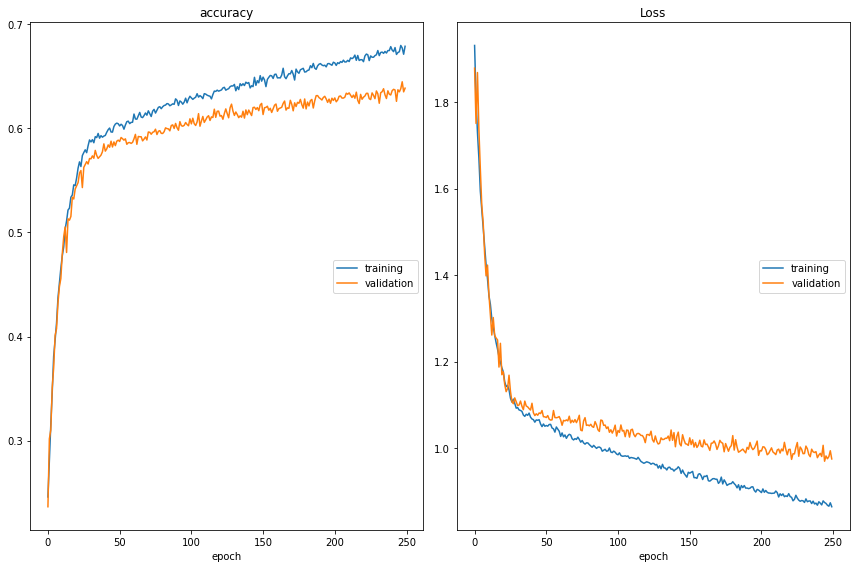

accuracy
	training         	 (min:    0.246, max:    0.680, cur:    0.679)
	validation       	 (min:    0.236, max:    0.645, cur:    0.639)
Loss
	training         	 (min:    0.865, max:    1.931, cur:    0.865)
	validation       	 (min:    0.970, max:    1.878, cur:    0.975)

Epoch 250: saving model to model_weights_final_final_finaaaallllll_wlh_finaal.h5
1513/1513 [==============================] - 30s 20ms/step - loss: 0.8649 - accuracy: 0.6789 - val_loss: 0.9753 - val_accuracy: 0.6387 - lr: 1.0000e-05


In [7]:
epochs = 250
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=False,mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2, min_lr=0.00001,model='auto')
callbacks = [PlotLossesKerasTF(),checkpoint, reduce_lr]

history = model.fit(x=train_generator,steps_per_epoch=steps_per_epoch,epochs=epochs,validation_data=validation_generator,validation_steps=validation_steps, callbacks=callbacks)

### Results and confusion matrix

Confusion Matrix
Confusion matrix, without normalization
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.11      0.12       955
        fear       0.13      0.05      0.07      1010
       happy       0.26      0.26      0.26      1770
     neutral       0.17      0.19      0.18      1233
         sad       0.18      0.25      0.21      1245
    surprise       0.11      0.14      0.12       817

    accuracy                           0.18      7030
   macro avg       0.17      0.17      0.16      7030
weighted avg       0.18      0.18      0.18      7030



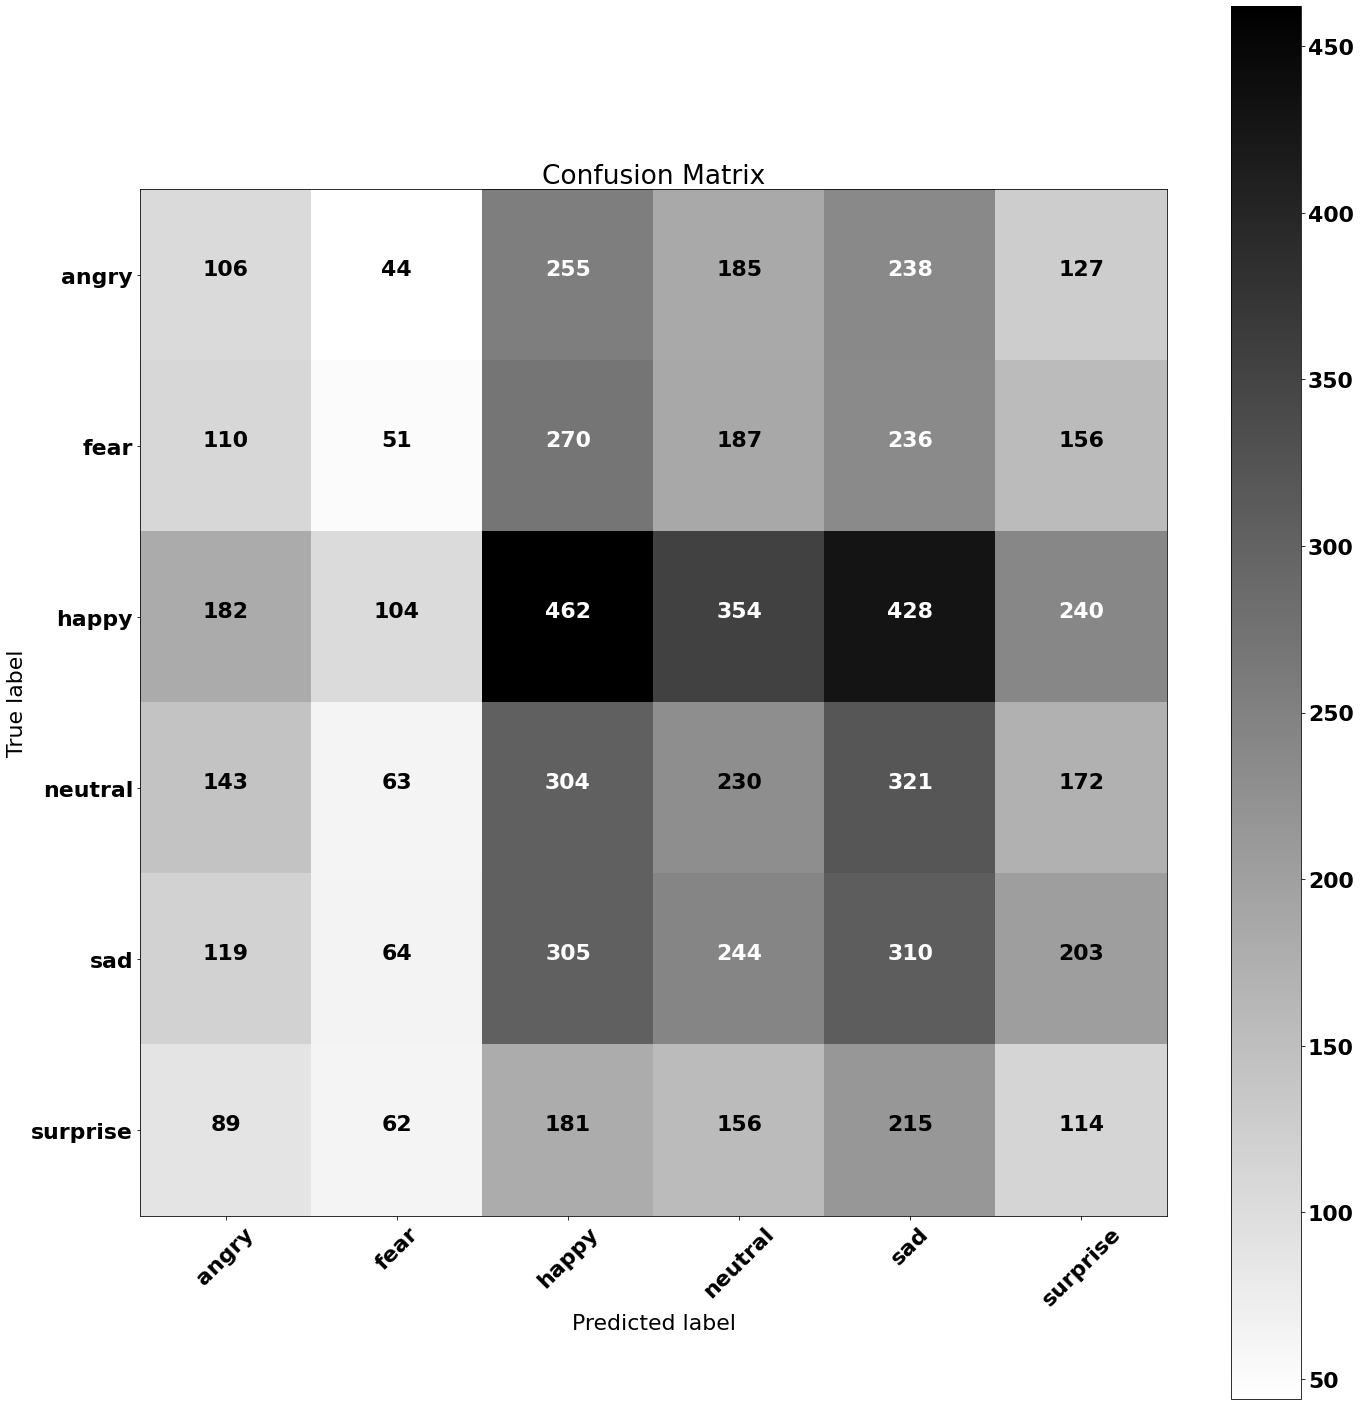

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.binary):
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
    plt.rc('font', **font)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
      cm = cm.astype('float') 
      cm = np.around(cm, decimals=2)
      cm[np.isnan(cm)] = 0.0
      print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn.metrics import classification_report, confusion_matrix
import itertools 

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

### Saving the model

In [ ]:
model_json=model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)